In [1]:
# Jax imports
import jax
import jax.numpy as jnp
from jax import jit
from jax import config
config.update("jax_enable_x64", False)

In [2]:
from matplotlib import pyplot as plt

In [1]:
# IO utils
from jax_2dtm.io import load_ccp4

ModuleNotFoundError: No module named 'jax_2dtm'

In [4]:
# Image simulator
from jax_2dtm.simulator import coordinatize, rotate_and_translate, project
from jax_2dtm.utils import ifft

In [5]:
# Volume filename and metadata
pixel_size = 1.1 # Angstroms
filename = "./example.mrc"

In [6]:
# Load volume
template = load_mrc(filename)
shape = template.shape

In [7]:
# Flatten volume and give it a coordinate system
volume, coords = coordinatize(template, pixel_size, eps=1e-5)

In [8]:
# Transform coordinates
phi, theta, psi, tx, ty = (0.0, 0.0, 0.0, 30.0, 20.0)
transformed_coords = rotate_and_translate(coords, phi, theta, psi, tx, ty)

In [12]:
# Compute scattering image
scattering_image = project(volume, transformed_coords, shape, pixel_size, eps=1e-4)

<class 'tensorflow.python.framework.ops.EagerTensor'> tf.Tensor(1e-04, shape=(), dtype=float32)


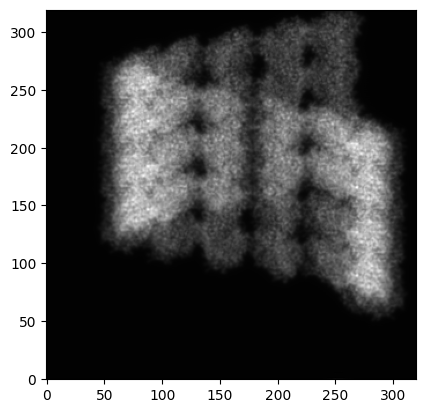

In [13]:
# Plot scattering image
plt.imshow(ifft(scattering_image), origin="lower", cmap="gray")